In [4]:
# Uninstall any old versions
!pip uninstall prophet -y
!pip uninstall fbprophet -y

# Install prophet with pystan 3 backend
!pip install prophet


Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 118.9 MB/s eta 0:00:00


In [11]:
# -----------------------------
# 1. Import Packages
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

# Set style
sns.set_style('whitegrid')


In [12]:
# -----------------------------
# 2. Create Synthetic Retail Data
# -----------------------------
stores = ['Store A', 'Store B', 'Store C', 'Store D', 'Store E']
products = ['Product 1', 'Product 2', 'Product 3', 'Product 4', 'Product 5']
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='W')  # weekly data

data = []
np.random.seed(42)

for store in stores:
    for product in products:
        base_sales = np.random.randint(50, 200)
        for date in dates:
            # Holiday effect: Black Friday (week 47), Christmas (week 52)
            holiday = 1 if date.isocalendar().week in [47, 52] else 0
            promotion = np.random.choice([0,1], p=[0.8,0.2])
            sales = base_sales + np.random.randint(-10,10) + holiday*50 + promotion*30
            data.append([store, product, date, sales, holiday, promotion])

df = pd.DataFrame(data, columns=['Store','Product','Date','Sales','Holiday','Promotion'])
df.head()


,Store,Product,Date,Sales,Holiday,Promotion
0,Store A,Product 1,2024-01-07,156,0,0
1,Store A,Product 1,2024-01-14,148,0,0
2,Store A,Product 1,2024-01-21,152,0,0
3,Store A,Product 1,2024-01-28,145,0,0
4,Store A,Product 1,2024-02-04,144,0,0


In [13]:
# -----------------------------
# 3. Forecast All Products/Stores
# -----------------------------
forecast_list = []

for store in df['Store'].unique():
    for product in df['Product'].unique():
        store_product = df[(df['Store']==store) & (df['Product']==product)]
        data_prophet = store_product[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})

        model = Prophet(weekly_seasonality=False, yearly_seasonality=True)
        # model.add_country_holidays(country_name='US')  # Optional
        model.fit(data_prophet)

        future = model.make_future_dataframe(periods=8, freq='W')  # 8 weeks for holiday season
        forecast = model.predict(future)

        forecast_subset = forecast[['ds','yhat']].tail(8)
        forecast_subset['Store'] = store
        forecast_subset['Product'] = product
        forecast_list.append(forecast_subset)

all_forecasts = pd.concat(forecast_list)
all_forecasts.rename(columns={'ds':'Date','yhat':'PredictedSales'}, inplace=True)
all_forecasts.head()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Date,PredictedSales,Store,Product
52,2025-01-05,222.904606,Store A,Product 1
53,2025-01-12,237.584453,Store A,Product 1
54,2025-01-19,233.499602,Store A,Product 1
55,2025-01-26,223.060486,Store A,Product 1
56,2025-02-02,219.063593,Store A,Product 1


In [14]:
# -----------------------------
# 4. Inventory Risk Analysis
# -----------------------------
np.random.seed(42)
all_forecasts['Inventory'] = np.random.randint(60,250,size=len(all_forecasts))
all_forecasts['StockoutRisk'] = all_forecasts['Inventory'] < all_forecasts['PredictedSales']
all_forecasts['Overstock'] = all_forecasts['Inventory'] > all_forecasts['PredictedSales']*1.2

all_forecasts.head()


,Date,PredictedSales,Store,Product,Inventory,StockoutRisk,Overstock
52,2025-01-05,222.904606,Store A,Product 1,162,True,False
53,2025-01-12,237.584453,Store A,Product 1,239,False,False
54,2025-01-19,233.499602,Store A,Product 1,152,True,False
55,2025-01-26,223.060486,Store A,Product 1,74,True,False
56,2025-02-02,219.063593,Store A,Product 1,166,True,False


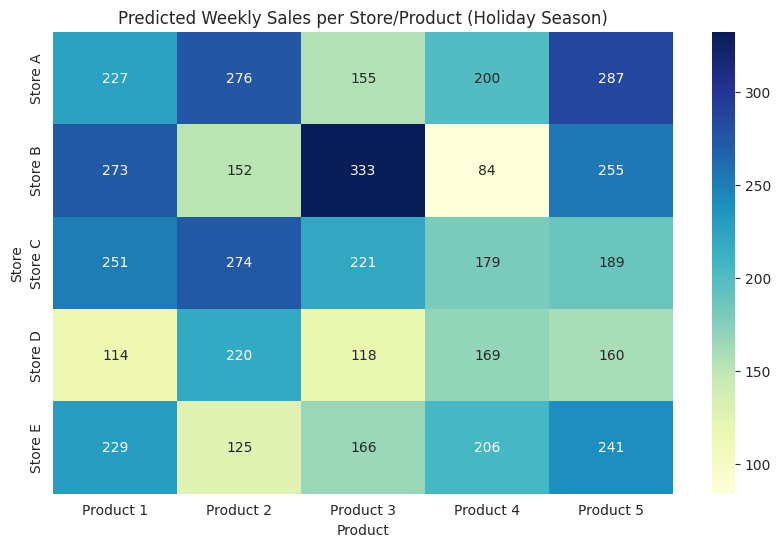

In [15]:
# -----------------------------
# 5. Heatmap: Average Predicted Sales per Store/Product
# -----------------------------
pivot = all_forecasts.groupby(['Store','Product'])['PredictedSales'].mean().reset_index()
pivot_table = pivot.pivot(index='Store', columns='Product', values='PredictedSales')

plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Predicted Weekly Sales per Store/Product (Holiday Season)')
plt.show()


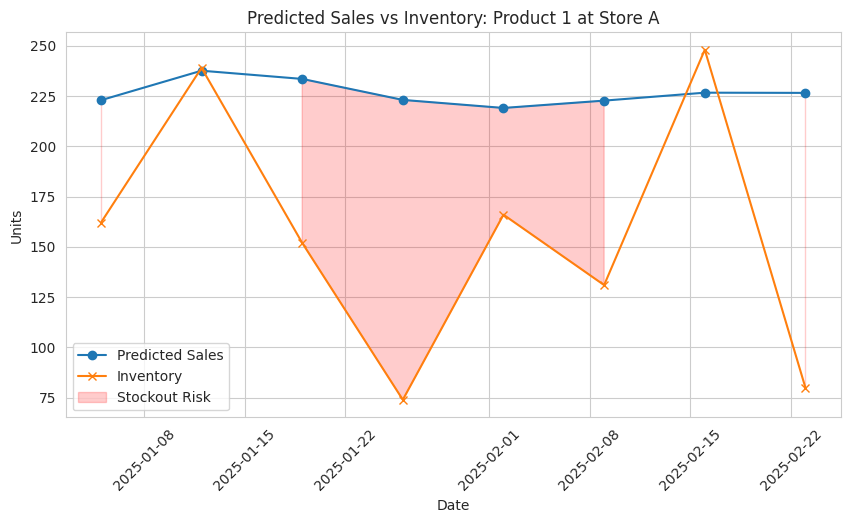

In [16]:
# -----------------------------
# 6. Line Chart: Predicted vs Inventory for Selected Product/Store
# -----------------------------
example = all_forecasts[(all_forecasts['Store']=='Store A') & (all_forecasts['Product']=='Product 1')]

plt.figure(figsize=(10,5))
plt.plot(example['Date'], example['PredictedSales'], marker='o', label='Predicted Sales')
plt.plot(example['Date'], example['Inventory'], marker='x', label='Inventory')
plt.fill_between(example['Date'], example['PredictedSales'], example['Inventory'],
                 where=(example['Inventory'] < example['PredictedSales']), color='red', alpha=0.2, label='Stockout Risk')
plt.title('Predicted Sales vs Inventory: Product 1 at Store A')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.xticks(rotation=45)
plt.show()
